In [1]:
import dask
import dask.dataframe as dd
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [3]:
train = dd.read_csv('train.csv', dtype=dtypes)
train = train.compute()

In [4]:
def update_feature_lists():
    binary = [c for c in train.columns if train[c].nunique() == 2]
    numerical = ['Census_ProcessorCoreCount',
                 'Census_PrimaryDiskTotalCapacity',
                 'Census_SystemVolumeTotalCapacity',
                 'Census_TotalPhysicalRAM',
                 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                 'Census_InternalPrimaryDisplayResolutionHorizontal',
                 'Census_InternalPrimaryDisplayResolutionVertical',
                 'Census_InternalBatteryNumberOfCharges']
    categorical = [c for c in train.columns if (c not in numerical) & (c not in binary)]
    return binary, numerical, categorical
    
binary_columns, true_numerical_columns, categorical_columns = update_feature_lists()

In [5]:
print('Dataset number of records: %s' % train.shape[0])
print('Dataset number of columns: %s' % train.shape[1])
train.head()

Dataset number of records: 8921483
Dataset number of columns: 83


,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.00,0,NaN,53447.00,...,36144.00,0,NaN,0.00,0,0,0.00,0.00,10.00,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.00,0,NaN,53447.00,...,57858.00,0,NaN,0.00,0,0,0.00,0.00,8.00,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.00,0,NaN,53447.00,...,52682.00,0,NaN,0.00,0,0,0.00,0.00,3.00,0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.00,0,NaN,53447.00,...,20050.00,0,NaN,0.00,0,0,0.00,0.00,3.00,1
4,000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.00,0,NaN,53447.00,...,19844.00,0,0.00,0.00,0,0,0.00,0.00,1.00,1


In [6]:
total = train.shape[0]
missing_df = []
cardinality_df = []
for col in train.columns:
    missing_df.append([col, train[col].count(), total])
    cardinality = train[col].nunique()
    if cardinality > 2 and col != 'MachineIdentifier':
        cardinality_df.append([col, cardinality])
    
missing_df = pd.DataFrame(missing_df, columns=['Column', 'Number of records', 'Total']).sort_values("Number of records", ascending=False)
cardinality_df = pd.DataFrame(cardinality_df, columns=['Column', 'Cardinality']).sort_values("Cardinality", ascending=False)
type_df = [['Binary columns', len(binary_columns)], ['Numerical columns', len(true_numerical_columns)], ['Categorical columns', len(categorical_columns)]]
type_df = pd.DataFrame(type_df, columns=['Type', 'Column count']).sort_values('Column count', ascending=True)

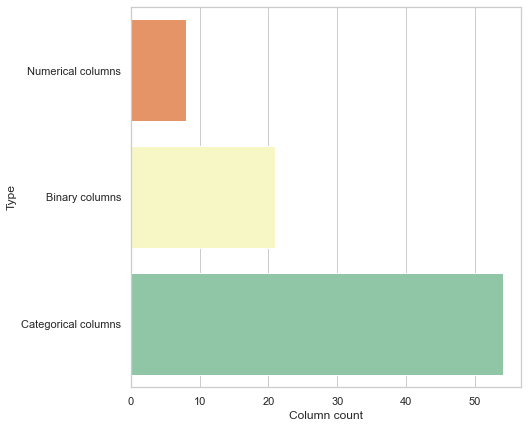

In [7]:
f, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x="Column count", y="Type", data=type_df, label="Missing", palette='Spectral')
plt.show()

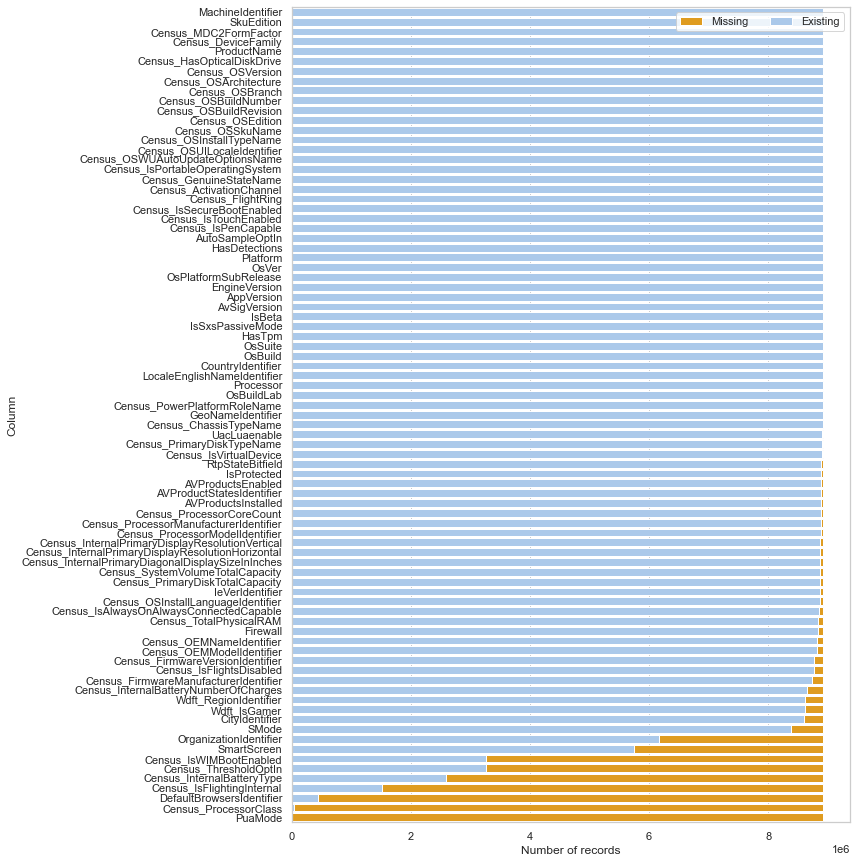

In [8]:
f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
sns.barplot(x="Total", y="Column", data=missing_df, label="Missing", color="orange")
sns.barplot(x="Number of records", y="Column", data=missing_df, label="Existing", color="b")
ax.legend(ncol=2, loc="upper right", frameon=True)
plt.show()

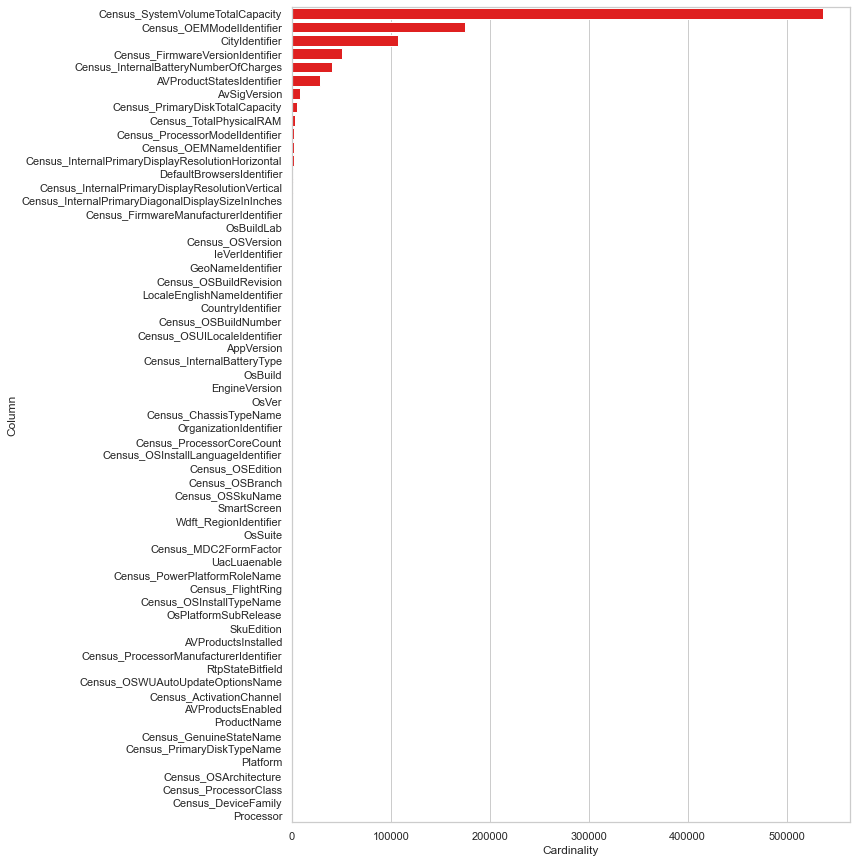

In [9]:
f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
sns.barplot(x="Cardinality", y="Column", data=cardinality_df, label="Existing", color="red")
plt.show()

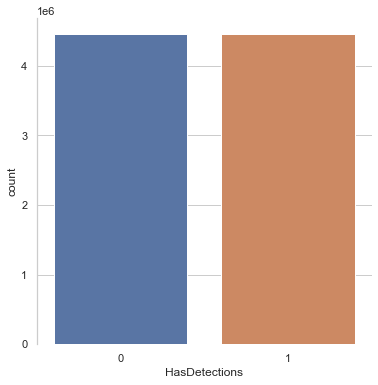

In [10]:
f, ax = plt.subplots(figsize=(6, 6))
ax = sns.countplot(x="HasDetections", data=train, label="Label count")
sns.despine(bottom=True)

In [11]:
high_cardinality_columns = [c for c in categorical_columns if train[c].nunique() > 500]
high_cardinality_columns.remove('MachineIdentifier')  # Remove ID
train.drop(high_cardinality_columns, axis=1, inplace=True)
print('Columns with high cardinality: ', high_cardinality_columns)

Columns with high cardinality:  ['AvSigVersion', 'DefaultBrowsersIdentifier', 'AVProductStatesIdentifier', 'CityIdentifier', 'OsBuildLab', 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorModelIdentifier', 'Census_FirmwareManufacturerIdentifier', 'Census_FirmwareVersionIdentifier']


In [12]:
high_null_columns = [c for c in train.columns if train[c].count() < len(train)*0.6]
train.drop(high_null_columns, axis=1, inplace=True)
print('Columns with more than 40% null values: ', high_null_columns)

Columns with more than 40% null values:  ['PuaMode', 'Census_ProcessorClass', 'Census_InternalBatteryType', 'Census_IsFlightingInternal', 'Census_ThresholdOptIn', 'Census_IsWIMBootEnabled']


In [13]:
unwanted_columns = ['MachineIdentifier']
train.drop(unwanted_columns, axis=1, inplace=True)

In [14]:
# Remove rows from numeric features with missing values (need this to plot distributions)
train.dropna(subset=true_numerical_columns, inplace=True)

In [15]:
binary_columns, true_numerical_columns, categorical_columns = update_feature_lists()

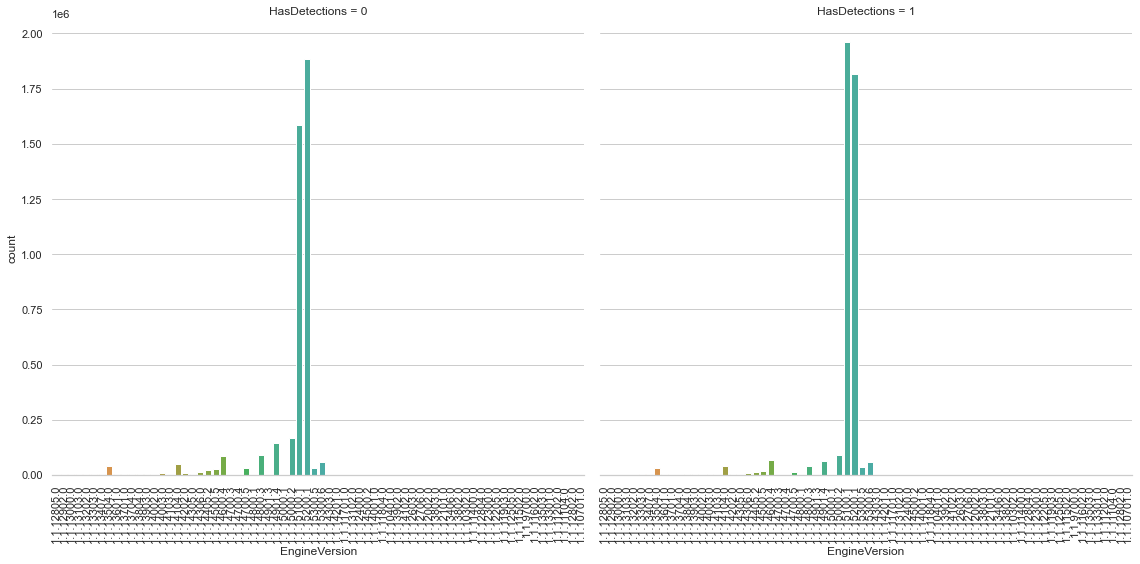

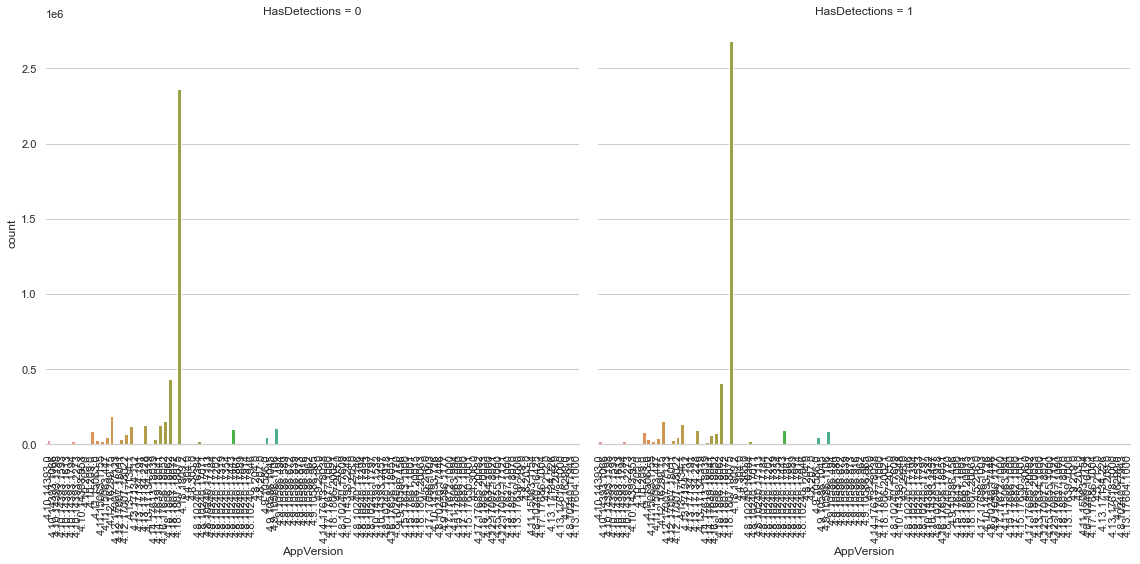

In [16]:
def plot_label_distribution():
    for feature in (binary_columns + categorical_columns):
        if 'Version' in feature and feature != 'Census_OSVersion':
            sns.catplot(data=train, x=feature, col="HasDetections", kind="count", height=8).set_xticklabels(rotation=90)
            sns.despine(left=True)
            plt.tight_layout()

plot_label_distribution()

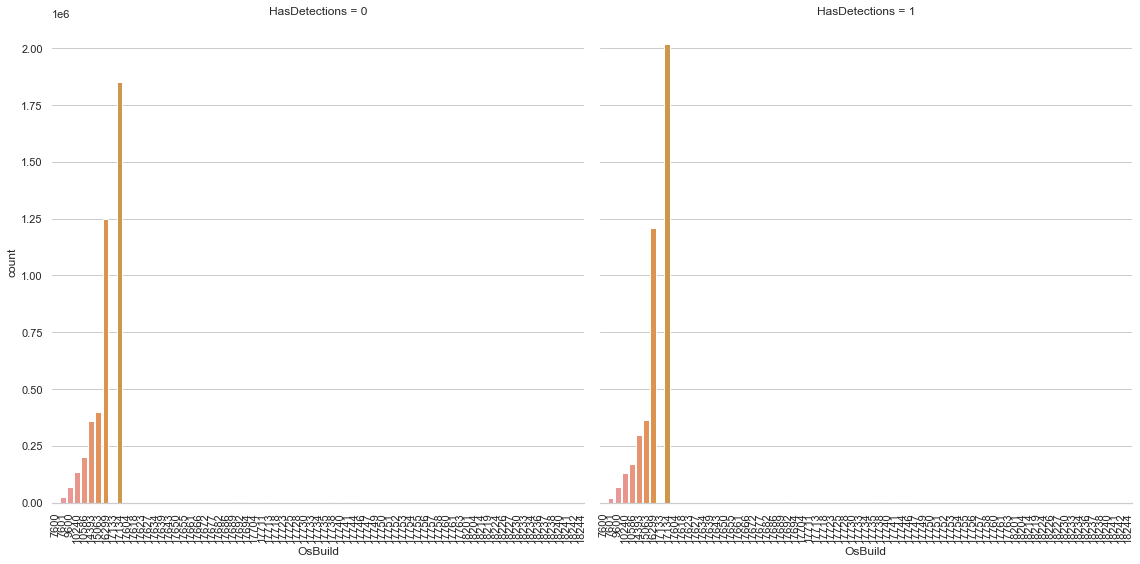

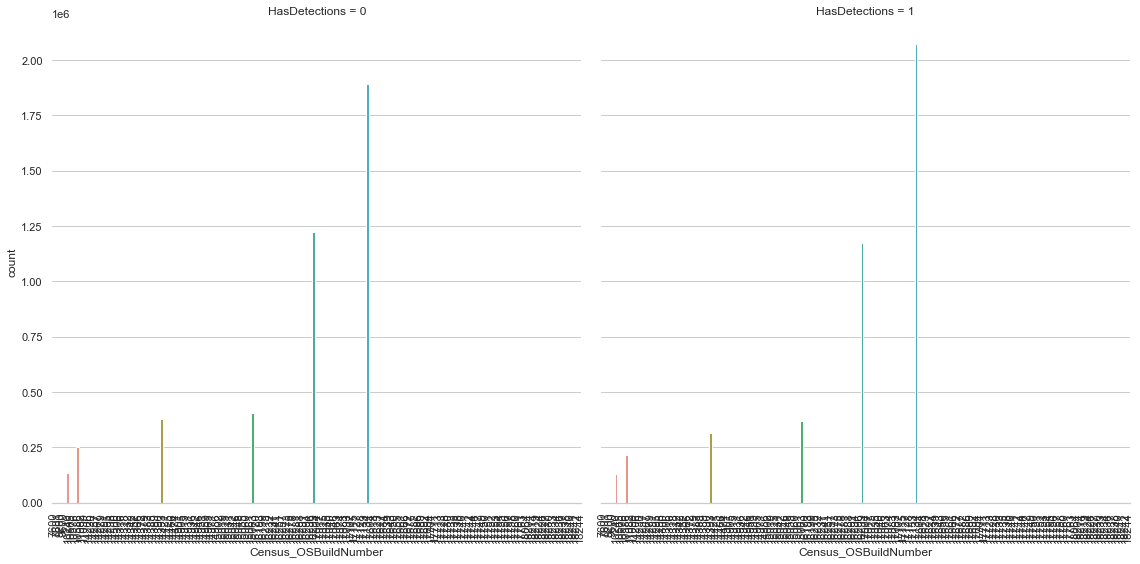

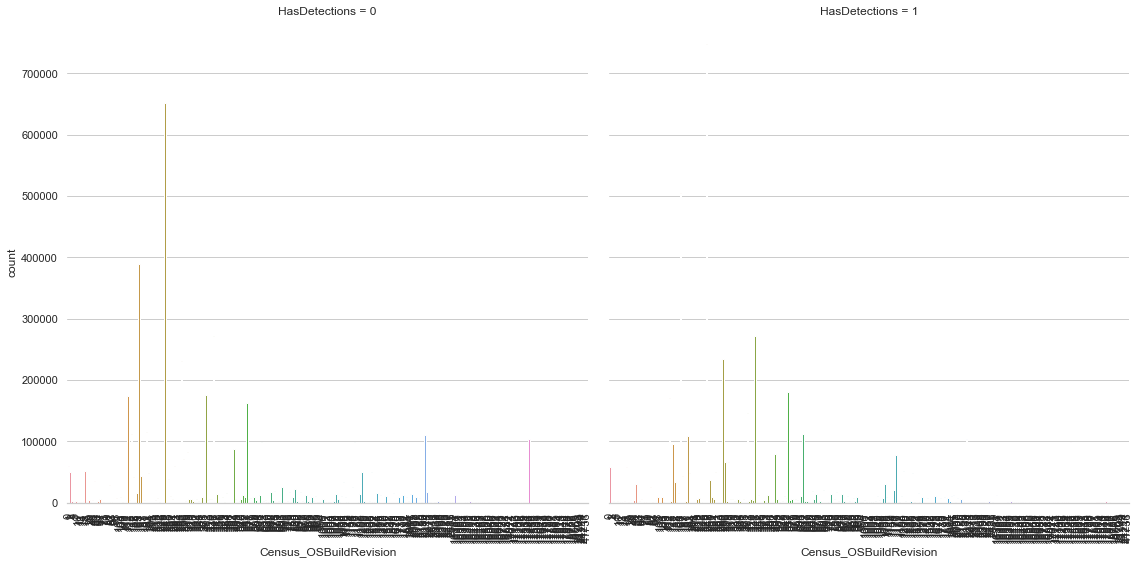

In [17]:
def plot_label_distribution():
    for feature in (binary_columns + categorical_columns):
        if 'Build' in feature and feature != 'OsBuildLab':
            sns.catplot(data=train, x=feature, col="HasDetections", kind="count", height=8).set_xticklabels(rotation=90)
            sns.despine(left=True)
            plt.tight_layout()

plot_label_distribution()

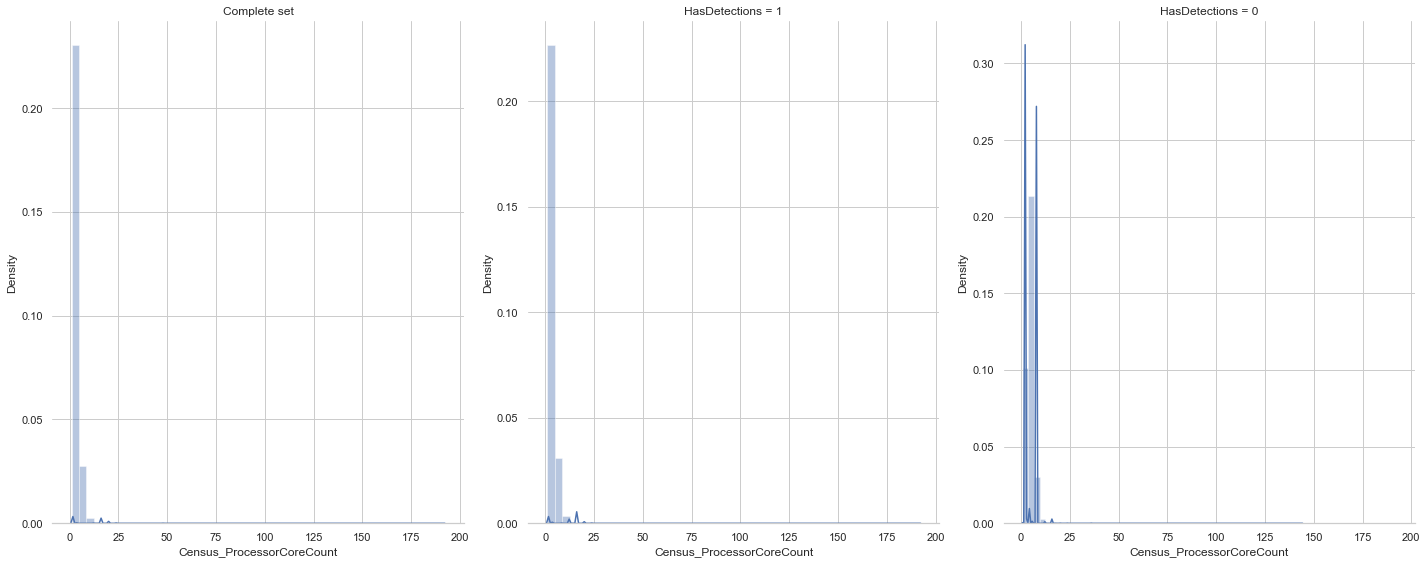

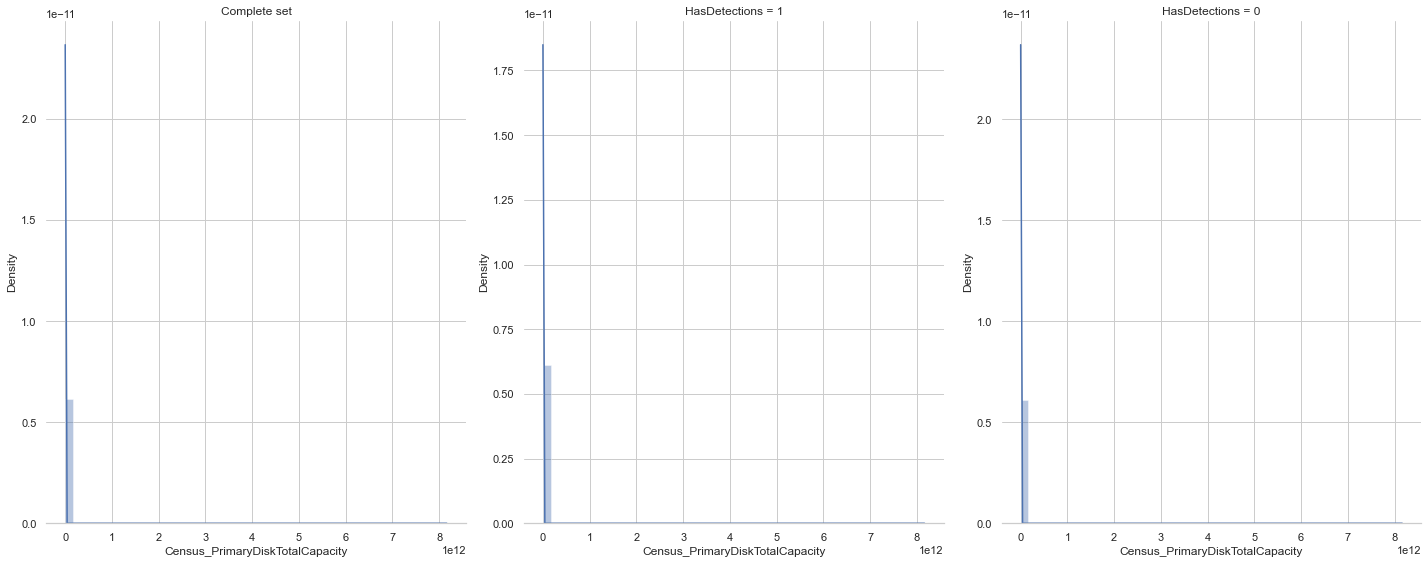

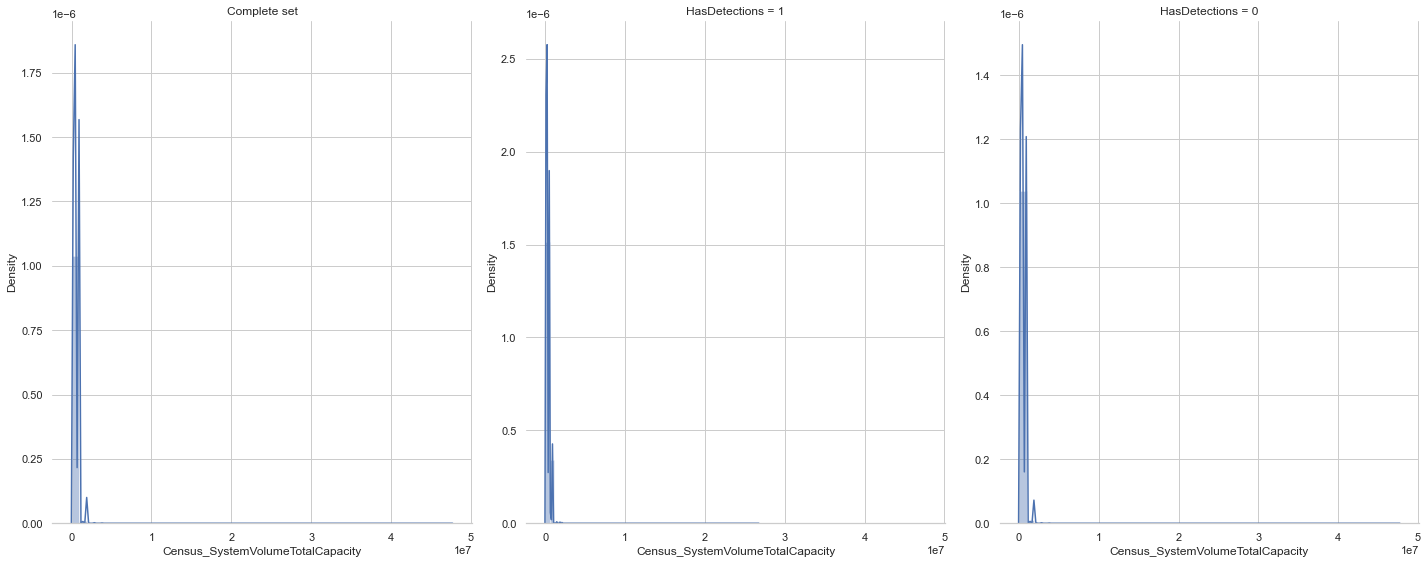

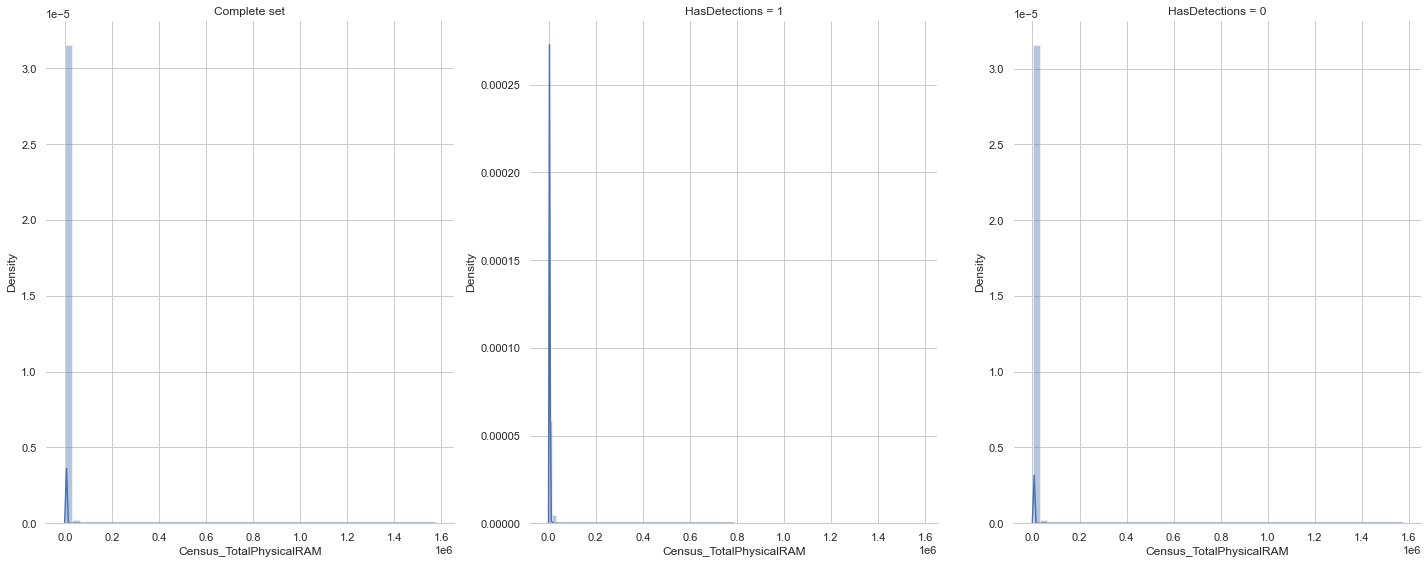

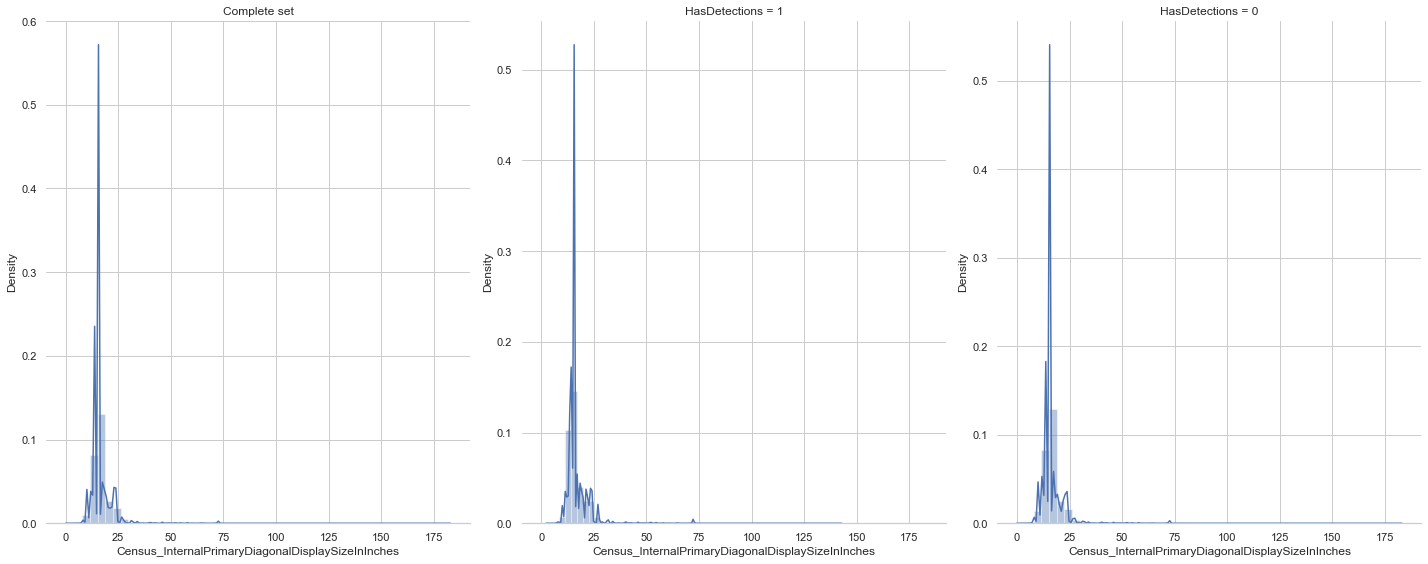

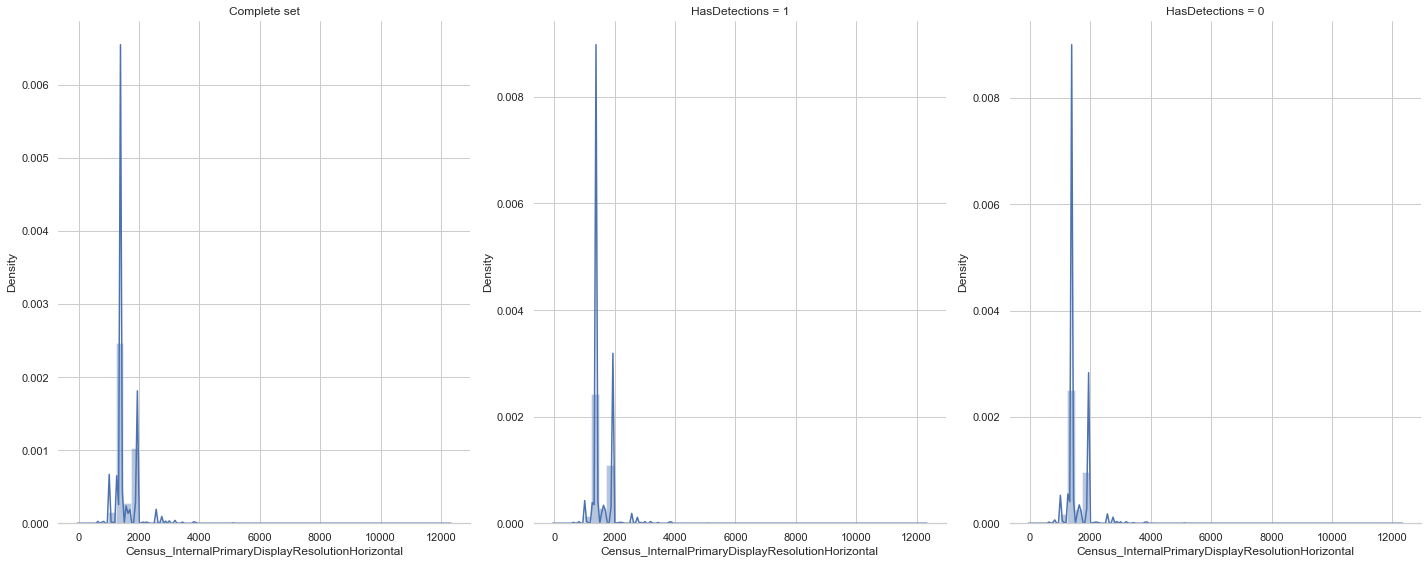

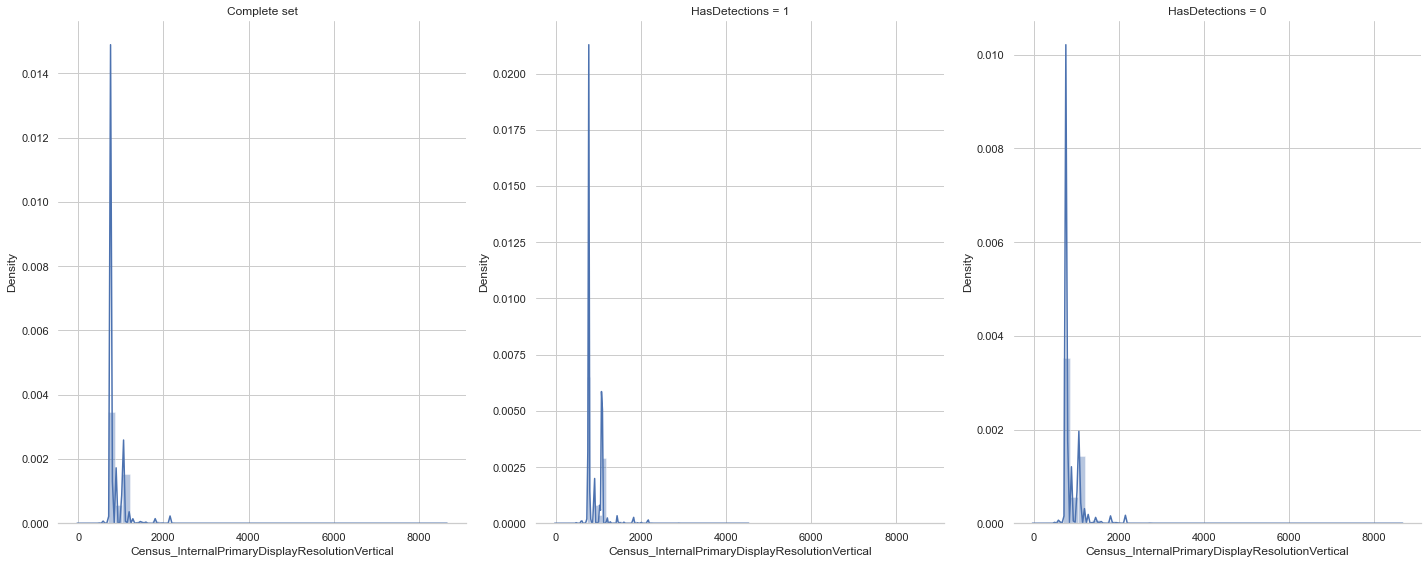

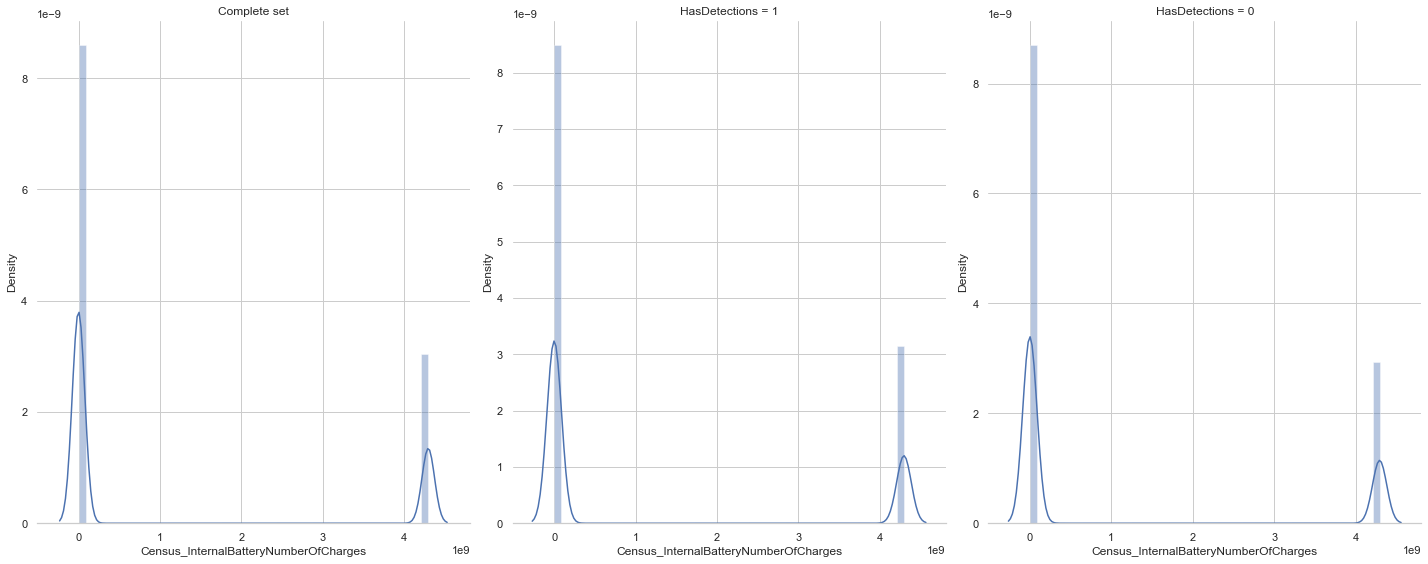

In [18]:
def plot_distribution():
    for feature in true_numerical_columns:
        f, axes = plt.subplots(1, 3, figsize=(20, 8), sharex=True)
        sns.distplot(train[feature], ax=axes[0]).set_title("Complete set")
        sns.distplot(train[train['HasDetections']==1][feature], ax=axes[1]).set_title("HasDetections = 1")
        sns.distplot(train[train['HasDetections']==0][feature], ax=axes[2]).set_title("HasDetections = 0")
        sns.despine(left=True)
        plt.tight_layout()

plot_distribution()

In [19]:
train.head()

,ProductName,EngineVersion,AppVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Census_IsFlightsDisabled,Census_FlightRing,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,win8defender,1.1.15100.1,4.18.1807.18075,0,7.00,0,1.00,1.00,1,29,...,0.00,Retail,0,0.00,0,0,0.00,0.00,10.00,0
1,win8defender,1.1.14600.4,4.13.17134.1,0,7.00,0,1.00,1.00,1,93,...,0.00,NOT_SET,0,0.00,0,0,0.00,0.00,8.00,0
2,win8defender,1.1.15100.1,4.18.1807.18075,0,7.00,0,1.00,1.00,1,86,...,0.00,Retail,0,0.00,0,0,0.00,0.00,3.00,0
3,win8defender,1.1.15100.1,4.18.1807.18075,0,7.00,0,1.00,1.00,1,88,...,0.00,Retail,0,0.00,0,0,0.00,0.00,3.00,1
4,win8defender,1.1.15100.1,4.18.1807.18075,0,7.00,0,1.00,1.00,1,18,...,0.00,Retail,0,0.00,0,0,0.00,0.00,1.00,1


In [20]:
train[true_numerical_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
Census_ProcessorCoreCount,8585688.00,NaN,0.00,1.00,2.00,4.00,4.00,192.00
Census_PrimaryDiskTotalCapacity,8585688.00,3006892.50,4524349440.00,0.00,239372.00,476940.00,953869.00,8160436813824.00
Census_SystemVolumeTotalCapacity,8585688.00,382814.78,323253.44,0.00,120815.00,249604.00,475978.00,47687100.00
Census_TotalPhysicalRAM,8585688.00,6124.35,4987.17,255.00,4096.00,4096.00,8192.00,1572864.00
Census_InternalPrimaryDiagonalDisplaySizeInInches,8585688.00,NaN,0.00,0.70,13.90,15.50,17.20,182.25
Census_InternalPrimaryDisplayResolutionHorizontal,8585688.00,NaN,NaN,-1.00,1366.00,1366.00,1920.00,12288.00
Census_InternalPrimaryDisplayResolutionVertical,8585688.00,NaN,NaN,-1.00,768.00,768.00,1080.00,8640.00
Census_InternalBatteryNumberOfCharges,8585688.00,1122106240.00,1931297920.00,0.00,0.00,0.00,4294967296.00,4294967296.00


In [21]:
# Remove rows with NA
train.dropna(inplace=True)

In [22]:
# Get labels
labels = train['HasDetections']
train.drop('HasDetections', axis=1, inplace=True)

X_train, X_val, Y_train, Y_val = train_test_split(train, labels, test_size=0.15,random_state=1)

In [23]:
binary_columns, true_numerical_columns, categorical_columns = update_feature_lists()

# Label encoder
indexer = {}
for col in categorical_columns:
    _, indexer[col] = pd.factorize(X_train[col])
    
for col in categorical_columns:
    X_train[col] = indexer[col].get_indexer(X_train[col])
    X_val[col] = indexer[col].get_indexer(X_val[col])

In [24]:
params = {'num_leaves': 60,
         'min_data_in_leaf': 100, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 1,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}

In [25]:
lgb_train = lgb.Dataset(X_train, label=Y_train)
lgb_val = lgb.Dataset(X_val, label=Y_val)

In [26]:
model = lgb.train(params, lgb_train, 10000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=200, verbose_eval=100)

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.740788	valid_1's auc: 0.739968
[200]	training's auc: 0.745803	valid_1's auc: 0.74364
[300]	training's auc: 0.748734	valid_1's auc: 0.745125
[400]	training's auc: 0.751062	valid_1's auc: 0.745939
[500]	training's auc: 0.753026	valid_1's auc: 0.746419
[600]	training's auc: 0.754929	valid_1's auc: 0.746912
[700]	training's auc: 0.756639	valid_1's auc: 0.747225
[800]	training's auc: 0.758261	valid_1's auc: 0.747456
[900]	training's auc: 0.759768	valid_1's auc: 0.747585
[1000]	training's auc: 0.761288	valid_1's auc: 0.747788
[1100]	training's auc: 0.762696	valid_1's auc: 0.747902
[1200]	training's auc: 0.764046	valid_1's auc: 0.747993
[1300]	training's auc: 0.765339	valid_1's auc: 0.747995
[1400]	training's auc: 0.766613	valid_1's auc: 0.748057
[1500]	training's auc: 0.767871	valid_1's auc: 0.748161
[1600]	training's auc: 0.769056	valid_1's auc: 0.748138
[1700]	training's auc: 0.770244	valid_1's auc: 0.748

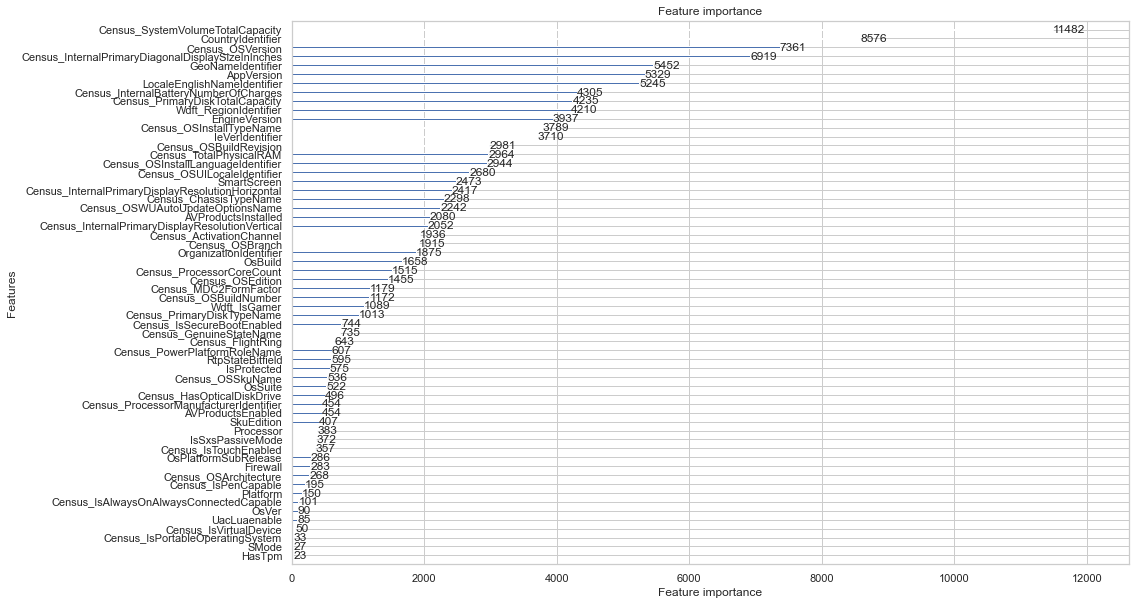

In [27]:
lgb.plot_importance(model, figsize=(15, 10))
plt.show()

In [28]:
train_predictions_raw = model.predict(X_train, num_iteration=model.best_iteration)
val_predictions_raw = model.predict(X_val, num_iteration=model.best_iteration)

train_predictions = np.around(train_predictions_raw)
val_predictions = np.around(val_predictions_raw)

In [29]:
target_names=['HasDetections = 0', 'HasDetections = 1']
print('-----Train-----')
print(classification_report(Y_train, train_predictions, target_names=target_names))
print('-----Validation-----')
print(classification_report(Y_val, val_predictions, target_names=target_names))

-----Train-----
                   precision    recall  f1-score   support

HasDetections = 0       0.68      0.72      0.70   1409602
HasDetections = 1       0.72      0.68      0.70   1510157

         accuracy                           0.70   2919759
        macro avg       0.70      0.70      0.70   2919759
     weighted avg       0.70      0.70      0.70   2919759

-----Validation-----
                   precision    recall  f1-score   support

HasDetections = 0       0.66      0.69      0.68    249299
HasDetections = 1       0.70      0.66      0.68    265953

         accuracy                           0.68    515252
        macro avg       0.68      0.68      0.68    515252
     weighted avg       0.68      0.68      0.68    515252



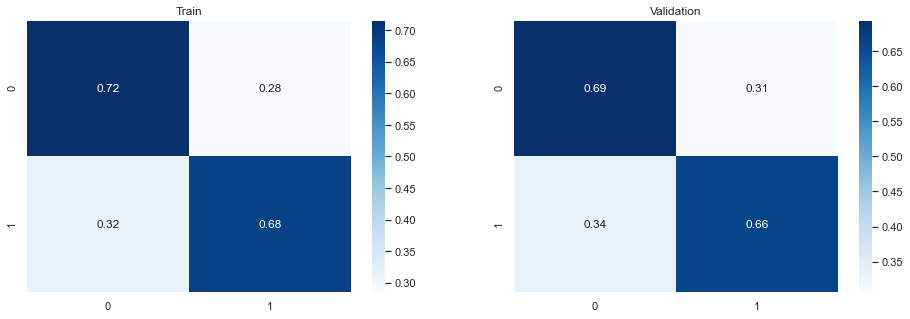

In [30]:
f, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(Y_train, train_predictions)
val_cnf_matrix = confusion_matrix(Y_val, val_predictions)

train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
val_cnf_matrix_norm = val_cnf_matrix / val_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
val_df_cm = pd.DataFrame(val_cnf_matrix_norm, index=[0, 1], columns=[0, 1])

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=axes[0]).set_title("Train")
sns.heatmap(val_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=axes[1]).set_title("Validation")
plt.show()

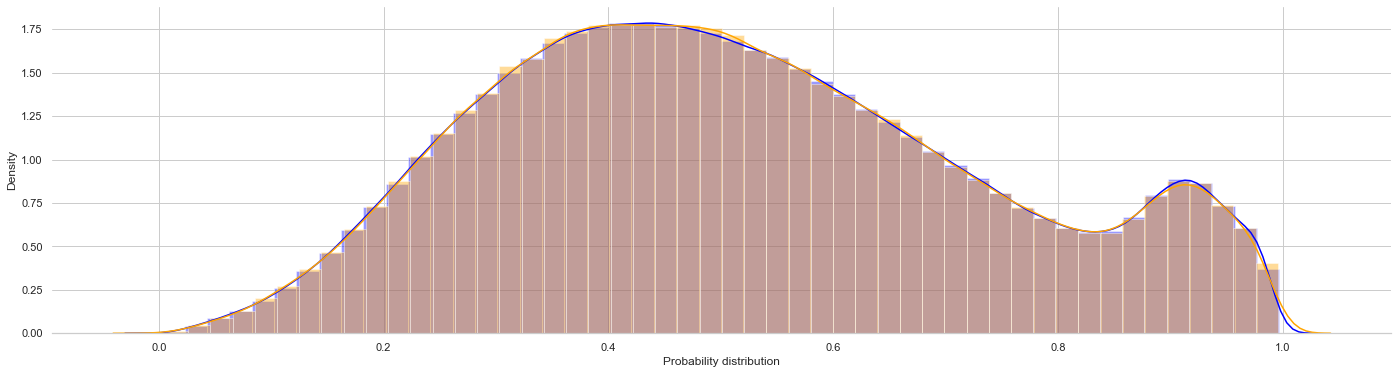

In [31]:
f, ax = plt.subplots(figsize=(24, 6))
sns.set_color_codes("pastel")
ax = sns.distplot(train_predictions_raw, color="blue", kde_kws={"label": "Train"}, axlabel='Probability distribution')
ax = sns.distplot(val_predictions_raw, color="orange", kde_kws={"label": "Validation"})
sns.despine(left=True)

In [32]:
# Because of memory issues I'm loading only part of test set.
test = dd.read_csv('test.csv', dtype=dtypes, usecols=(['MachineIdentifier'] + list(X_train.columns))).head(n=1000000)

In [33]:
submission = pd.DataFrame({"MachineIdentifier":test['MachineIdentifier']})
test.drop('MachineIdentifier', axis=1, inplace=True)

for col in categorical_columns:
    test[col] = indexer[col].get_indexer(test[col])

In [34]:
predictions = model.predict(test, num_iteration=model.best_iteration)

In [35]:
submission["HasDetections"] = predictions
submission.to_csv("submission.csv", index=False)
submission.head(10)

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.95
1,00000176ac758d54827acd545b6315a5,0.30
2,0000019dcefc128c2d4387c1273dae1d,0.36
3,0000055553dc51b1295785415f1a224d,0.35
4,00000574cefffeca83ec8adf9285b2bf,0.48
5,000007ffedd31948f08e6c16da31f6d1,0.83
6,000008f31610018d898e5f315cdf1bd1,0.58
7,00000a3c447250626dbcc628c9cbc460,0.58
8,00000b6bf217ec9aef0f68d5c6705897,0.90
9,00000b8d3776b13e93ad83676a28e4aa,0.37
